# DataTable Transformation Graph Example

In [19]:
from pyMez.Code.DataHandlers.Translations import *
from pyMez.Code.DataHandlers.GraphModels import *
from ipywidgets import *
import h5py

In [42]:
options={}
options["data"]=[[1,2,3],[4,5,6]]
options["column_names"]=['a','b','c']
options["header"]=["The First Line"]
table=AsciiDataTable(None,**options)
#table=OnePortCalrepModel(os.path.join(TESTS_DIRECTORY,'700437.asc'))
table=TwoPortRawModel(os.path.join(TESTS_DIRECTORY,'TestFileTwoPortRaw.txt'))
#table=SNP(os.path.join(TESTS_DIRECTORY,'Solution_0.s4p'))
data_frame=AsciiDataTable_to_DataFrameDictionary(table)

data_frame=AsciiDataTable_to_DataFrameDictionary(TwoPortRawModel(os.path.join(TESTS_DIRECTORY,'TestFileTwoPortRaw.txt')))

In [84]:
graph_options={"graph_name":"Data Table Graph",
                  "node_names":['DataFrameDictionary','AsciiDataTable'],
                  "node_descriptions":["Pandas Data Frame Dictionary","AsciiDataTable"],
                  "current_node":'DataFrameDictionary',
                  "state":[1,0],
                  "data":data_frame,
                  "edge_2_to_1":AsciiDataTable_to_DataFrameDictionary,
                  "edge_1_to_2":DataFrameDictionary_to_AsciiDataTable
                 }
data_table_graph=Graph(**graph_options)

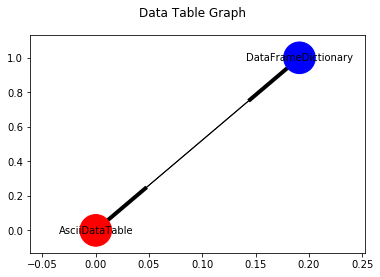

In [80]:
data_table_graph.show()

In [25]:
print(data_table_graph.data)
data_table_graph.move_to_node("AsciiDataTable")
print(data_table_graph.data)

{'Header':                                   Header_Line_Content
0                                        HP8510      
1                                                  L 
2                                                    
3                                             N      
4                                     2-port         
5                                      9 Sep 2015    
6                                          10:31:55  
7                                          MEASLP    
8                                          150122    
9                                          BFR       
10                                    c050211.a2     
11                                                   
12                                                  1
13                                                  3
14                                                  1
15                                                  4
16                                                 53
17               

In [73]:
def DataFrameDictionary_to_AsciiDataTable(DataFrame_dict,**options):
    """Given a dictionary of pandas DataFrames returns an AsciiDataTable"""
    defaults={"comment_begin":"!","comment_end":"\n",
             "column_names_begin_token":"!","column_names_end_token":"\n",
              "data_delimiter":"  ","data_table_element_separator":None}
    #defaults={}
    table_options={}
    for key,value in defaults.iteritems():
        table_options[key]=value
    for key,value in options.iteritems():
        table_options[key]=value
    keys=DataFrame_dict.keys()
    for key in keys:
        table_key=key
        if re.search("comments",key,re.IGNORECASE):
            table_key="inline_comments"
            table_options[table_key]=DataFrame_dict[key].as_matrix().tolist()
            
        elif key in ["data","Data"]:
            table_options["column_names"]=DataFrame_dict[key].columns.tolist()
            table_options["column_types"]=map(lambda x: str(x),DataFrame_dict[key].dtypes.tolist())
            table_options["data"]=DataFrame_dict[key].as_matrix().tolist()
            
        elif re.search("footer",key,re.IGNORECASE):
            list_of_lists=DataFrame_dict[key].as_matrix().tolist()
            list_of_strings=[str(row[0]) for row in list_of_lists]
            table_options["footer"]=list_of_strings
            
        elif re.search("header",key,re.IGNORECASE):
            table_options["treat_header_as_comment"]=True
            list_of_lists=DataFrame_dict[key].as_matrix().tolist()
            list_of_strings=[str(row[0]) for row in list_of_lists]
            #print("{0} is {1}".format("list_of_lists",list_of_lists))
            table_options["header"]=list_of_strings
            
        elif re.search("meta",key,re.IGNORECASE):
            list_of_lists=DataFrame_dict[key].as_matrix().tolist()
            dictionary={str(row[0]):str(row[1]) for row in list_of_lists}
            table_options["metadata"]=dictionary            

    new_table=AsciiDataTable(None,**table_options)
    return new_table

def DataFrameDictionary_to_ExcelFile(DataFrameDictionary,excel_file_name="Test.xlsx"):
    """Converts a dictionary of pandas DataFrames to a single excel file with sheet names
    determined by keys"""
    # sort the keys so that they will display in the same order
    writer = pandas.ExcelWriter(excel_file_name)
    keys=sorted(DataFrameDictionary.keys())
    for key in keys:
        #print key
        DataFrameDictionary[key].to_excel(writer,sheet_name=key,index=False)
        #print("Writing {0}".format(key))
        
    writer.close()
    return excel_file_name

def DataFrameDictionary_to_HdfFile(DataFrame_dict,hdf_file_name="Test.hd5"):
    """Transforms a dictionary of pandas.DataFrames to a single HD5 file with groups determined by the keys"""
    keys=sorted(DataFrame_dict.keys())
    for key in keys:
        DataFrame_dict[key].to_hdf(hdf_file_name,key)
    print("{0} is {1}".format('key',key))
    return hdf_file_name

def HdfFile_to_DataFrameDictionary(hdf_file_name):
    """Creates a dictionary of pandas.DataFrames given a hd5 file name, does this require the table names?
    """
    hdf=h5py.File(hdf_file_name)
    keys=hdf.keys()
    pandas_dictionary={key:pandas.read_hdf(hdf_file_name,key) for key in keys}
    return pandas_dictionary

def AsciiDataTable_to_CsvFile(ascii_data_table,file_name="test.csv",schema_file_name="schema_csv"):
    """Converts an AsciiDataTable into an csv file by setting options and saving"""
    original_options=ascii_data_table.options.copy()
    ascii_data_table.options["column_names_begin_token"]=""
    ascii_data_table.options["column_names_end_token"]="\n"
    ascii_data_table.options["data_table_element_separator"]=None
    ascii_data_table.options["data_begin_token"]=None
    ascii_data_table.options["data_end_token"]=None
    ascii_data_table.options["data_delimiter"]=","
    ascii_data_table.options["column_names_delimiter"]=","
    if ascii_data_table.header is not None:
        ascii_data_table.options["comment_begin"]="#"
        ascii_data_table.options["comment_end"]="\n"
        ascii_data_table.options["treat_header_as_comment"]=True
    if ascii_data_table.footer is not None:
        ascii_data_table.options["comment_begin"]="#"
        ascii_data_table.options["comment_end"]="\n"       
        ascii_data_table.options["treat_footer_as_comment"]=True
    #ascii_data_table.update_model()
    ascii_data_table.save_schema(schema_file_name)
    ascii_data_table.save(file_name)
    ascii_data_table.options=original_options
    return [file_name,schema_file_name]

def AsciiDataTable_to_HpFile(ascii_data_table,file_name="test.txt",schema_file_name="schema_hp"):
    """Converts an AsciiDataTable into an csv file by setting options and saving"""
    original_options=ascii_data_table.options.copy()
    ascii_data_table.options["column_names_begin_token"]="!"
    ascii_data_table.options["column_names_end_token"]="\n"
    ascii_data_table.options["data_table_element_separator"]=None
    ascii_data_table.options["data_begin_token"]=None
    ascii_data_table.options["data_end_token"]=None
    ascii_data_table.options["data_delimiter"]="  "
    ascii_data_table.options["column_names_delimiter"]="  "
    if ascii_data_table.header is not None:
        ascii_data_table.options["comment_begin"]="!"
        ascii_data_table.options["comment_end"]="\n"
        ascii_data_table.options["treat_header_as_comment"]=True
    if ascii_data_table.footer is not None:
        ascii_data_table.options["comment_begin"]="!"
        ascii_data_table.options["comment_end"]="\n"
        #ascii_data_table.options["treat_header_as_comment"]=True
        ascii_data_table.options["treat_footer_as_comment"]=True
    #ascii_data_table.update_model()
    ascii_data_table.save_schema(schema_file_name)
    ascii_data_table.save(file_name)
    ascii_data_table.options=original_options
    return [file_name,schema_file_name]

def File_to_AsciiDataTable(paths):
    [file_name,schema]=paths
    options=read_schema(schema)
    table=AsciiDataTable(file_name,**options)
    print table
    return table
    
def AsciiDataTable_to_File(ascii_data_table,file_name="Test.txt",schema_file_name="schema"):
    paths=[file_name,schema_file_name]
    ascii_data_table.save(file_name)
    ascii_data_table.save_schema(schema_file_name)
    return paths    


In [97]:
graph_options={"graph_name":"Data Table Graph",
                  "node_names":['DataFrameDictionary','AsciiDataTable'],
                  "node_descriptions":["Pandas Data Frame Dictionary","AsciiDataTable"],
                  "current_node":'DataFrameDictionary',
                  "state":[1,0],
                  "data":data_frame,
                  "edge_2_to_1":AsciiDataTable_to_DataFrameDictionary,
                  "edge_1_to_2":DataFrameDictionary_to_AsciiDataTable
                 }
data_table_graph=Graph(**graph_options)
data_table_graph.add_node("ExcelFile","DataFrameDictionary",DataFrameDictionary_to_ExcelFile,
                    "DataFrameDictionary",ExcelFile_to_DataFrameDictionary,node_description="Excel Workbook")
data_table_graph.add_node("HdfFile","DataFrameDictionary",DataFrameDictionary_to_HdfFile,
                    "DataFrameDictionary",HdfFile_to_DataFrameDictionary,node_description="HD5 File")
data_table_graph.add_node("CsvFile","AsciiDataTable",AsciiDataTable_to_CsvFile,
                    "AsciiDataTable",File_to_AsciiDataTable,node_description="CSV File")
data_table_graph.add_node("HpFile","AsciiDataTable",AsciiDataTable_to_HpFile,
                    "AsciiDataTable",File_to_AsciiDataTable,node_description="hp format File")
data_table_graph.add_external_node(external_node_name="XMLDataTable",jump_into_node_begin="AsciiDataTable",
                                   jump_into_node_function=AsciiDataTable_to_XmlDataTable,
                                   external_node_description="XMLDataTable")
                                  

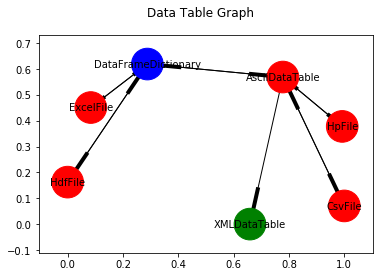

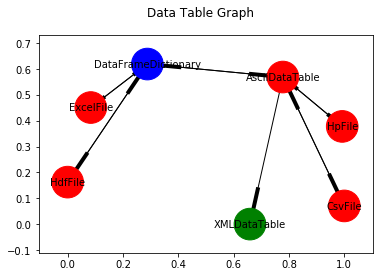

In [103]:
data_table_graph.show()

********************************************************************************
Excel Workbook [0, 0, 1, 0, 0, 0]
********************************************************************************


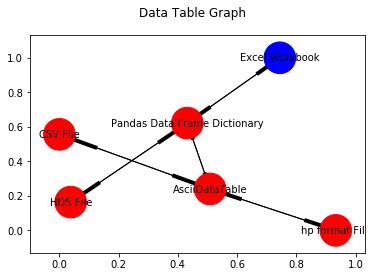

Test.xlsx


In [89]:
%matplotlib inline
history=[]
def move_and_show(end_node_number):
    node=data_table_graph.node_names[end_node_number]
    data_table_graph.move_to_node(node)
    print("*"*80)
    print("{0}".format(data_table_graph.node_descriptions[end_node_number])+" {0}".format(data_table_graph.state))
    print("*"*80)
    data_table_graph.show(descriptions=True)
    print data_table_graph.data
    history.append(node)
    
interact(move_and_show,end_node_number=(0,len(data_table_graph.node_names)-1,1))

In [61]:
DataFrameDictionary_to_ExcelFile(data_frame,excel_file_name="NewExcel.xlsx")

Writing Data
Writing Header
Writing Metadata


'NewExcel.xlsx'

In [52]:
data_frame.keys()

['Header', 'Data', 'Metadata']

In [66]:
DataFrameDictionary_to_ExcelFile.__doc__

'Converts a dictionary of pandas DataFrames to a single excel file with sheet names\n    determined by keys'

In [90]:
data_table_graph.move_to_node("AsciiDataTable")
xml=AsciiDataTable_to_XmlDataTable(data_table_graph.data)

In [94]:
html=HTMLBase(None,html_text=xml.to_HTML(os.path.join(TESTS_DIRECTORY,"../XSL/DEFAULT_MEASUREMENT_STYLE.xsl")))

In [95]:
html.show()

file://c:/users/sandersa/appdata/local/temp/1/tmprydvif.html


In [104]:
class DataTableGraph(Graph):
    """     Class that transforms a row modelled header and metadata to several different data types
        #!python
        defaults={"graph_name":"Data Table Graph",
                  "node_names":['DataFrameDictionary','AsciiDataTable'],
                  "node_descriptions":["Pandas Data Frame Dictionary","AsciiDataTable"],
                  "current_node":'DataFrameDictionary',
                  "state":[1,0],
                  "data":AsciiDataTable_to_DataFrameDictionary(TwoPortRawModel(os.path.join(TESTS_DIRECTORY,'TestFileTwoPortRaw.txt'))),
                  "edge_2_to_1":AsciiDataTable_to_DataFrameDictionary,
                  "edge_1_to_2":DataFrameDictionary_to_AsciiDataTable
                 }
        """
    def __init__(self,**options):

        defaults={"graph_name":"Data Table Graph",
                  "node_names":['DataFrameDictionary','AsciiDataTable'],
                  "node_descriptions":["Pandas Data Frame Dictionary","AsciiDataTable"],
                  "current_node":'DataFrameDictionary',
                  "state":[1,0],
                  "data":AsciiDataTable_to_DataFrameDictionary(TwoPortRawModel(os.path.join(TESTS_DIRECTORY,'TestFileTwoPortRaw.txt'))),
                  "edge_2_to_1":AsciiDataTable_to_DataFrameDictionary,
                  "edge_1_to_2":DataFrameDictionary_to_AsciiDataTable
                 }
        graph_options={}
        for key,value in defaults.iteritems():
            graph_options[key]=value
        for key,value in options.iteritems():
            graph_options[key]=value
        Graph.__init__(self, **graph_options)

        self.add_node("ExcelFile", "DataFrameDictionary", DataFrameDictionary_to_ExcelFile,
                                  "DataFrameDictionary", ExcelFile_to_DataFrameDictionary,
                                  node_description="Excel Workbook")
        self.add_node("HdfFile", "DataFrameDictionary", DataFrameDictionary_to_HdfFile,
                                  "DataFrameDictionary", HdfFile_to_DataFrameDictionary, node_description="HD5 File")
        self.add_node("CsvFile", "AsciiDataTable", AsciiDataTable_to_CsvFile,
                                  "AsciiDataTable", File_to_AsciiDataTable, node_description="CSV File")
        self.add_node("HpFile", "AsciiDataTable", AsciiDataTable_to_HpFile,
                                  "AsciiDataTable", File_to_AsciiDataTable, node_description="hp format File")
        self.add_external_node(external_node_name="XMLDataTable", jump_into_node_begin="AsciiDataTable",
                                           jump_into_node_function=AsciiDataTable_to_XmlDataTable,
                                           external_node_description="XMLDataTable")


In [105]:
test_graph_2=DataTableGraph()

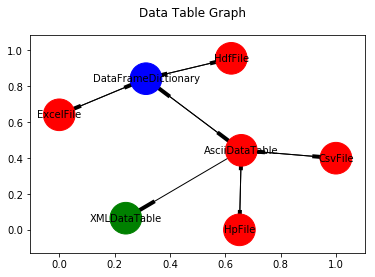

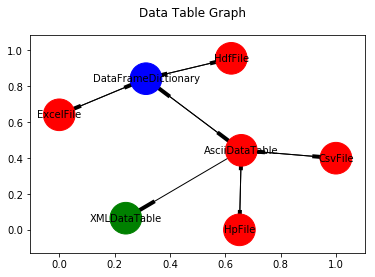

In [106]:
test_graph_2.show()

********************************************************************************
AsciiDataTable [0, 1, 0, 0, 0, 0]
********************************************************************************


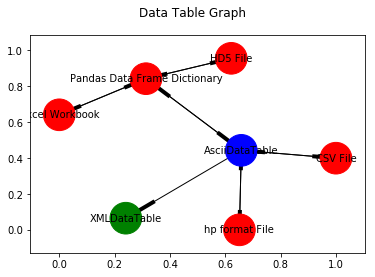

!HP8510      
!L 
!N      
!2-port         
! 9 Sep 2015    
!10:31:55  
!MEASLP    
!150122    
!BFR       
!c050211.a2     
! 1
! 3
! 1
!  4
!  53
!  7
!CHECK STANDARD 20 dB ATTEN                                  
!CTN208              
!Frequency,Direction,Connect,magS11,argS11,magS21,argS21,magS22,argS22
0.1  1  1  0.0154  169.133  0.103905610881  -7.217  0.00485  154.908
0.1  1  2  0.0154  169.077  0.103900586721  -7.214  0.00485  155.141
0.1  1  3  0.01543  169.124  0.103912190506  -7.215  0.00484  155.075
0.15  1  1  0.01481  168.127  0.103890658737  -10.792  0.00478  134.684
0.15  1  2  0.01481  168.035  0.103882525675  -10.792  0.00477  134.945
0.15  1  3  0.01484  168.094  0.103889941089  -10.792  0.00477  134.925
0.2  1  1  0.01498  160.938  0.103875349972  -14.363  0.00521  125.588
0.2  1  2  0.01499  160.904  0.103865185242  -14.364  0.0052  125.781
0.2  1  3  0.01502  160.978  0.103871762307  -14.364  0.0052  125.735
0.25  1  1  0.01483  158.35  0.103839478892  -17.919  0.

In [107]:
%matplotlib inline
history=[]
def move_and_show(end_node_number):
    node=test_graph_2.node_names[end_node_number]
    test_graph_2.move_to_node(node)
    print("*"*80)
    print("{0}".format(test_graph_2.node_descriptions[end_node_number])+" {0}".format(test_graph_2.state))
    print("*"*80)
    test_graph_2.show(descriptions=True)
    print test_graph_2.data
    history.append(node)
    
interact(move_and_show,end_node_number=(0,len(test_graph_2.node_names)-1,1))

In [108]:
ks=KnowledgeSystem()

In [109]:
print ks

Property
Self
Default


In [110]:
ks